# Example-Create-Population-Auto-West-London

This notebook demonstrates an example workflow for creating a sample population automatically for west London area. It creates test agent plans of person and households. 

In [48]:
from shapely.geometry import Point

from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim
from pam.plot.stats import plot_activity_times, plot_leg_times

In [49]:
import numpy as np
from random import choice

import geopandas as gp
from matplotlib import pyplot as plt

In [50]:
# Import geographic data of west london area
network_bb_path = "fixtures/network_bounding_box.geojson"
lsoas_path = "fixtures/lsoas" #lsoas: lower layer super output areas 

epsg:4326


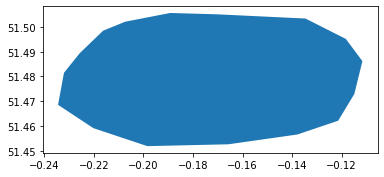

In [51]:
# read the file and plot the boundary
boundary = gp.read_file(network_bb_path)
print(boundary.crs)
boundary.plot()

epsg:27700


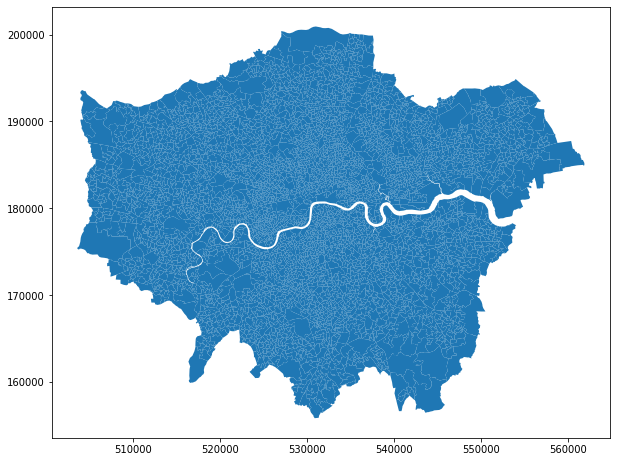

In [52]:
# Read the lsoas and plot the boundary
lsoas = gp.read_file(lsoas_path)
print(lsoas.crs)
lsoas.plot(figsize=(10,10))

In [30]:
lsoas.head()

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18..."
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18..."
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18..."


epsg:27700
epsg:4326


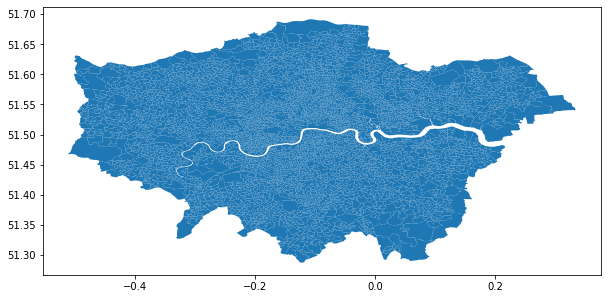

In [32]:
# Use same spatial coordinate system
lsoas = gp.read_file(lsoas_path)
print(lsoas.crs)
lsoas = lsoas.to_crs("epsg:4326")
print(lsoas.crs)
lsoas.plot(figsize=(10,10))

4326 is just the EPSG identifier of WGS84.

WGS84 comprises a standard coordinate frame for the Earth, a datum/reference ellipsoid for raw altitude data

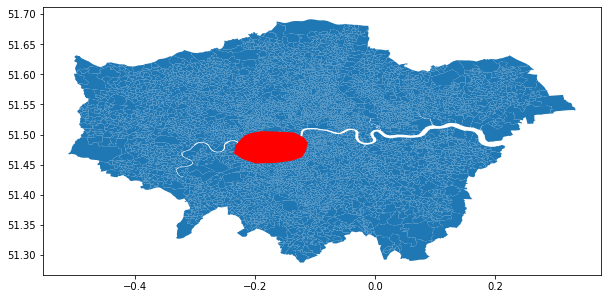

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
lsoas.plot(ax=ax)
boundary.plot(ax=ax, color='red')

In [34]:
lsoas

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((-0.09814 51.51985, -0.09857 51.51973..."
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((-0.09508 51.51824, -0.09524 51.51901..."
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((-0.09772 51.52292, -0.09679 51.52325..."
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((-0.11106 51.51383, -0.11155 51.51522..."
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((-0.07915 51.51632, -0.07822 51.51749..."
...,...,...,...,...,...,...,...,...,...
4760,E01004761,Westminster 018D,E02000977,Westminster 018,00BKGW,West End,00BK,Westminster,"POLYGON ((-0.15034 51.50921, -0.15059 51.50978..."
4761,E01004762,Westminster 011E,E02000970,Westminster 011,00BKGW,West End,00BK,Westminster,"POLYGON ((-0.15630 51.51000, -0.15840 51.51341..."
4762,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((-0.13988 51.51952, -0.13984 51..."
4763,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((-0.14869 51.51335, -0.15012 51.51309..."


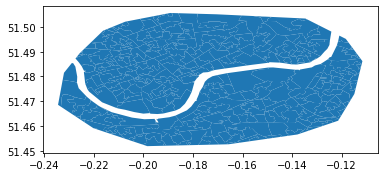

In [35]:
lsoas_clipped = gp.overlay(lsoas, boundary, how='intersection')
lsoas_clipped.plot()

In [36]:
lsoas_clipped.head()

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry
0,E01001851,Hammersmith and Fulham 010A,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((-0.21594 51.49863, -0.21600 51.49855..."
1,E01001855,Hammersmith and Fulham 010B,E02000381,Hammersmith and Fulham 010,00ANGA,Addison,00AN,Hammersmith and Fulham,"POLYGON ((-0.21292 51.49986, -0.21251 51.49958..."
2,E01001866,Hammersmith and Fulham 012A,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((-0.21239 51.49549, -0.21269 51.49629..."
3,E01001867,Hammersmith and Fulham 012B,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"POLYGON ((-0.21939 51.49379, -0.21846 51.49383..."
4,E01001868,Hammersmith and Fulham 012C,E02000383,Hammersmith and Fulham 012,00ANGC,Avonmore and Brook Green,00AN,Hammersmith and Fulham,"MULTIPOLYGON (((-0.20924 51.49436, -0.20908 51..."


In [82]:
# Random select a area and location
lsoas_clipped[["LSOA_CODE", "LA_NAME"]].sample()

,LSOA_CODE,LA_NAME
2,E01001866,Hammersmith and Fulham


{'num_households': 100, 'num_people': 100, 'num_activities': 300, 'num_legs': 200}
Person: agent_7
{'subpopulation': 'medium income', 'gender': 'male', 'age': 38}
0:	Activity(1 act:home, location:199    E01004499
Name: LSOA_CODE, dtype: object, time:00:00:00 --> 07:35:00, duration:7:35:00)
1:	Leg(1 mode:train, area:199    E01004499
Name: LSOA_CODE, dtype: object --> 95    E01002848
Name: LSOA_CODE, dtype: object, time:07:35:00 --> 08:11:00, duration:0:36:00)
2:	Activity(2 act:work, location:95    E01002848
Name: LSOA_CODE, dtype: object, time:08:11:00 --> 14:11:00, duration:6:00:00)
3:	Leg(2 mode:train, area:95    E01002848
Name: LSOA_CODE, dtype: object --> 216    E01004535
Name: LSOA_CODE, dtype: object, time:14:11:00 --> 15:03:00, duration:0:52:00)
4:	Activity(3 act:home, location:199    E01004499
Name: LSOA_CODE, dtype: object, time:15:03:00 --> 00:00:00, duration:8:57:00)
Person: agent_13
{'subpopulation': 'high income', 'gender': 'male', 'age': 26}
0:	Activity(1 act:home, locatio

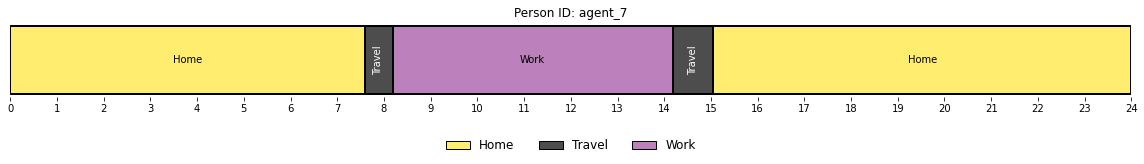

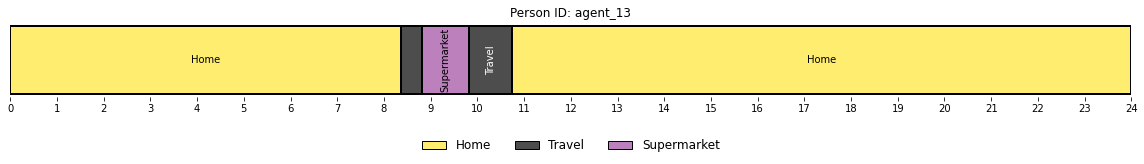

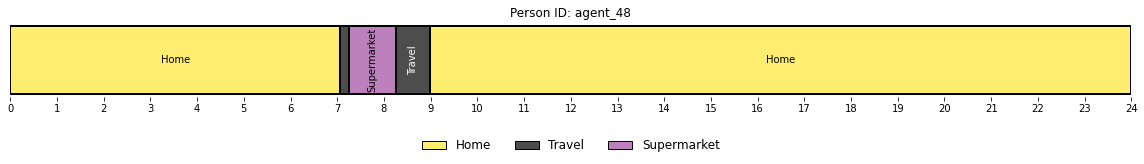

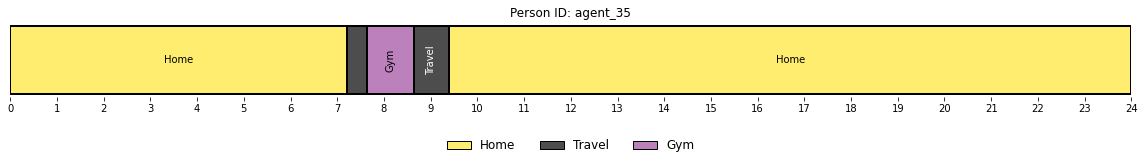

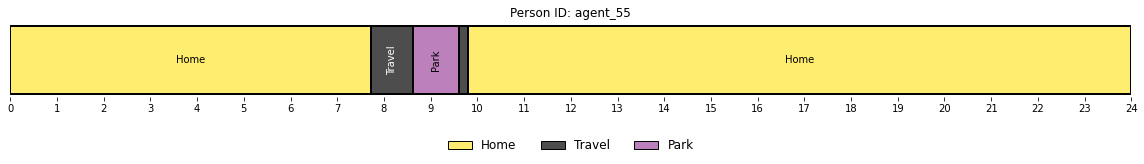

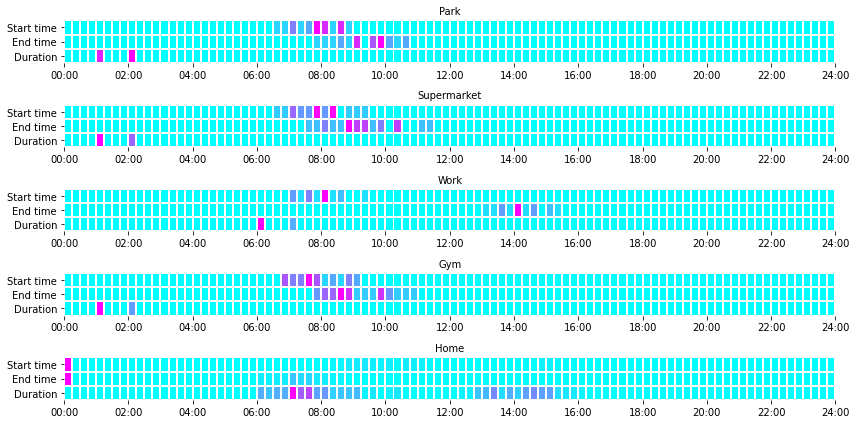

In [84]:
# Generate agents in west london area
def generate_agents(no_of_agents):
    population = Population() # Initialise an empty population
    
    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    
    # Create mode and activities
    transport= ["car", "train", "bus", "walk"]
    activity = ["work", "supermarket", "gym", "park"]

    
    for i in range(no_of_agents):
        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh_id = Household("agent_" + str(i))
        
        # print(hh_id)
        agent_id = Person(agent_id, attributes= {"subpopulation": np.random.choice(income) + " income",
                                                 "gender" : np.random.choice(gender),
                                                 "age": np.random.randint(10,70)
                                                })

        hh_id.add(agent_id)
        population.add(hh_id)
        
        # Adding Activities and Legs alternately to different agents
        # activity 1
        leaves = (np.random.randint(6,8) * 60) + np.random.randint(0,100)  # minutes
        location1 = lsoas_clipped[["LSOA_CODE", "LA_NAME"]].sample()
        agent_id.add(Activity(
        seq = 1,
        act ='home',
        area = location1["LA_NAME"],
        loc = location1["LSOA_CODE"],
        start_time = mtdt(0),
        end_time = mtdt(leaves)))

        # outbound leg
        arrives = leaves + np.random.randint(10,60)  # minutes
        location2 = lsoas_clipped[["LSOA_CODE", "LA_NAME"]].sample()
        agent_id.add(Leg(
            seq = 1,
            mode = np.random.choice(transport),
            start_area = location1["LA_NAME"],
            end_area = location2["LA_NAME"],
            start_loc = location1["LSOA_CODE"],
            end_loc = location2["LSOA_CODE"],
            start_time = mtdt(leaves),
            end_time = mtdt(arrives), 
        ))

        # activity 2
        random_act = np.random.choice(activity)
        if random_act == "work":
            leaves = arrives + (np.random.randint(6,8) * 60)
        else:
            leaves = arrives + (np.random.randint(1,3) * 60)
        agent_id.add(Activity(
            seq = 2,
            act = random_act,
            area = location2["LA_NAME"],
            loc = location2["LSOA_CODE"],
            start_time = mtdt(arrives),
            end_time = mtdt(leaves)
        ))       

        # inbound leg
        arrives = leaves + np.random.randint(10,60)  # minutes
        location3 = lsoas_clipped[["LSOA_CODE", "LA_NAME"]].sample()
        agent_id.add(Leg(
            seq = 2,
            mode = np.random.choice(transport),
            start_area = location2["LA_NAME"],
            end_area = location3["LA_NAME"],
            start_loc = location2["LSOA_CODE"],
            end_loc = location3["LSOA_CODE"],
            start_time = mtdt(leaves),
            end_time = mtdt(arrives), 
        ))

        # activity
        agent_id.add(Activity(
            seq = 3,
            act ='home',
            area = location1["LA_NAME"],
            loc = location1["LSOA_CODE"],
            start_time = mtdt(arrives),
            end_time = mtdt(24 * 60)
        ))
        
    print(population.stats)
    #
    for i in range(5):
        p = population.random_person()
        p.plot()
        p.print()
    
    fig = plot_activity_times(population)
    
    return population

#test
generate_agents(100)

## Further improvements
- Improve the diversity of activities 
- Modify the notebook by considering the distance of different locations and various time spent on transport and activities